In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [69]:
# Dominio de -1 a 1 en 64 datos debibo a los 6 genes
# 000 000, 000 001, ... , 111 111
x = np.linspace(-1, 1, 64)
y = x**2

print(x)
print(y)

[-1.         -0.96825397 -0.93650794 -0.9047619  -0.87301587 -0.84126984
 -0.80952381 -0.77777778 -0.74603175 -0.71428571 -0.68253968 -0.65079365
 -0.61904762 -0.58730159 -0.55555556 -0.52380952 -0.49206349 -0.46031746
 -0.42857143 -0.3968254  -0.36507937 -0.33333333 -0.3015873  -0.26984127
 -0.23809524 -0.20634921 -0.17460317 -0.14285714 -0.11111111 -0.07936508
 -0.04761905 -0.01587302  0.01587302  0.04761905  0.07936508  0.11111111
  0.14285714  0.17460317  0.20634921  0.23809524  0.26984127  0.3015873
  0.33333333  0.36507937  0.3968254   0.42857143  0.46031746  0.49206349
  0.52380952  0.55555556  0.58730159  0.61904762  0.65079365  0.68253968
  0.71428571  0.74603175  0.77777778  0.80952381  0.84126984  0.87301587
  0.9047619   0.93650794  0.96825397  1.        ]
[1.00000000e+00 9.37515747e-01 8.77047115e-01 8.18594104e-01
 7.62156715e-01 7.07734946e-01 6.55328798e-01 6.04938272e-01
 5.56563366e-01 5.10204082e-01 4.65860418e-01 4.23532376e-01
 3.83219955e-01 3.44923154e-01 3.08641

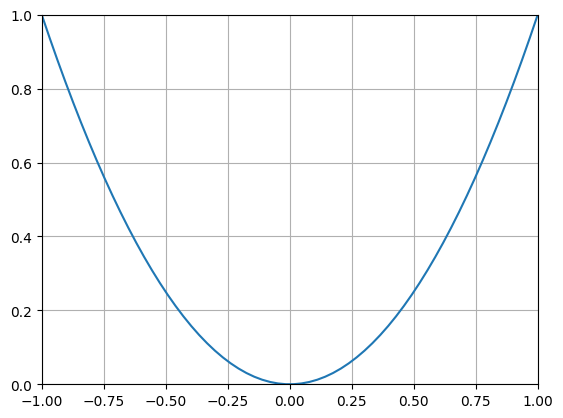

In [3]:
plt.plot(x, y)
plt.axis([-1, 1, 0, 1])
plt.grid(True)
plt.show()

No es necesario tener toda la poblacion generada, habra casos donde no se pueda generar todos y solo necesitamos 10 individuos para empezar la cruza, el objetivo es justamente con una poblacion pequeña alcanzar lo optimo.

# Generar Poblacion

In [225]:
step = 64
valores = np.linspace(-1, 1, step)  # 64 valores entre -1 y 1

def bin2val(binario, valores):
    idx = int(binario, 2)
    return valores[idx]

def generar_individuo():
    # Índice entre 0 y 63
    idx = random.randint(0, step-1)
    # Decimal a Binario
    binario = format(idx, '06b')
    valor = bin2val(binario, valores)
    return binario, valor

# Generar padres
padres = []
val = []
for _ in range(10):
    b, v = generar_individuo()
    padres.append(b)
    val.append(v)
    print(f"{b} -> {v}")


011111 -> -0.015873015873015928
110010 -> 0.5873015873015872
110110 -> 0.7142857142857142
100110 -> 0.20634920634920628
001100 -> -0.6190476190476191
001010 -> -0.6825396825396826
111000 -> 0.7777777777777777
000110 -> -0.8095238095238095
011011 -> -0.1428571428571429
000011 -> -0.9047619047619048


Creamos nuestra poblacion inicial junto con su aptitud

In [226]:
df = pd.DataFrame({
    'Bin': padres,
    'Valor': val
})
df['fitness'] = df['Valor']**2

In [227]:
display(df)

,Bin,Valor,fitness
0,011111,-0.015873,0.000252
1,110010,0.587302,0.344923
2,110110,0.714286,0.510204
3,100110,0.206349,0.042580
4,001100,-0.619048,0.383220
5,001010,-0.682540,0.465860
6,111000,0.777778,0.604938
7,000110,-0.809524,0.655329
8,011011,-0.142857,0.020408
9,000011,-0.904762,0.818594


Ordenar segun su aptitud

In [228]:
df.sort_values(by='fitness', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
#df.to_csv('poblacion_inicial.csv', index=False) # Guardar para replicar despues
display(df)

,Bin,Valor,fitness
0,000011,-0.904762,0.818594
1,000110,-0.809524,0.655329
2,111000,0.777778,0.604938
3,110110,0.714286,0.510204
4,001010,-0.682540,0.465860
5,001100,-0.619048,0.383220
6,110010,0.587302,0.344923
7,100110,0.206349,0.042580
8,011011,-0.142857,0.020408
9,011111,-0.015873,0.000252


Llevaremos un registro de las generaciones para lo cual tomaremos dos valores representativos de cada generacion, siendo estos el mejor valor de aptitud asi como el promedio de la generacion.  
Partiendo de los padres inicales esta sera nuestra Generacion 0.

In [229]:
df_hist = pd.DataFrame(columns=["Bin","Valor","fitness", "Avg_Fitness"])

def add_hist (df, df_hist):
    nuevo_registro = df.iloc[[0]].copy()
    nuevo_registro["Avg_Fitness"] = df["fitness"].mean()
    df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)
    return df_hist

In [230]:
df_hist = add_hist(df, df_hist)
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  000011 -0.904762  0.818594     0.384631


C:\Users\death\AppData\Local\Temp\ipykernel_23528\3672471164.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_hist = pd.concat([df_hist, nuevo_registro], ignore_index=True)


# Seleccion

Con nuestros 10 padres creados procedemos a la cruza  
Para esto haremos 5 parejas y cada una tendra 2 hijos


## Metodos de selección

Separaremos los padres en dos grupos segun su aptitud y usaremos dos metodos de selección, Rank y Torneo

Como proponemos 5 parejas y debido a sus aptitudes haremos 2 parejas con rank (Las que tienen mejor aptitud) y 3 por torneo(Con peor aptitud esperando que mejoren)

In [231]:
# Rank
df1 = df.iloc[:4]

# torneo
df2 = df.iloc[4:10]

In [232]:
display(df1)
display(df2)

,Bin,Valor,fitness
0,000011,-0.904762,0.818594
1,000110,-0.809524,0.655329
2,111000,0.777778,0.604938
3,110110,0.714286,0.510204


,Bin,Valor,fitness
4,001010,-0.682540,0.465860
5,001100,-0.619048,0.383220
6,110010,0.587302,0.344923
7,100110,0.206349,0.042580
8,011011,-0.142857,0.020408
9,011111,-0.015873,0.000252


### Rank
Formaremos parejas segun su rango de aptitud tomando asi:  
(1 - 2), (3 - 4), (5 - 6)

In [233]:
df_rs = df1.reset_index(drop=True) # Reiniciar índice para hacer nuestra cruza
display(df_rs)

,Bin,Valor,fitness
0,000011,-0.904762,0.818594
1,000110,-0.809524,0.655329
2,111000,0.777778,0.604938
3,110110,0.714286,0.510204


In [234]:
def parejas_rank(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    for i in range(0, len(df_rs)-1, 2):
        if i+1 < len(df_rs):
            pareja = (df_rs.iloc[i], df_rs.iloc[i+1])
            parejas.append(pareja)
    return parejas

def cruza_corte(parejas, corte_n):
    hijos = []
    for p1, p2 in parejas:
        bin1 = p1['Bin']
        bin2 = p2['Bin']
        hijo1_bin = bin1[:corte_n] + bin2[corte_n:]
        hijo2_bin = bin2[:corte_n] + bin1[corte_n:]
        hijos.append(hijo1_bin)
        hijos.append(hijo2_bin)
    return hijos


In [235]:
parejas = parejas_rank(df1)
hijos_binarios = cruza_corte(parejas, 3)

for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 000011
Padre 2 Bin: 000110
---
Pareja 2:
Padre 1 Bin: 111000
Padre 2 Bin: 110110
---
Hijo 1 Bin: 000110
Hijo 2 Bin: 000011
Hijo 3 Bin: 111110
Hijo 4 Bin: 110000


In [236]:
gen1 = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1['Valor'] = gen1['Bin'].apply(lambda b: bin2val(b, valores))
gen1['fitness'] = gen1['Valor']**2

gen1_r = pd.concat([df_rs, gen1], ignore_index=True)

In [237]:
gen1_r.sort_values(by='fitness', ascending=False, inplace=True)
display(gen1_r)

,Bin,Valor,fitness
6,111110,0.968254,0.937516
0,000011,-0.904762,0.818594
5,000011,-0.904762,0.818594
1,000110,-0.809524,0.655329
4,000110,-0.809524,0.655329
2,111000,0.777778,0.604938
3,110110,0.714286,0.510204
7,110000,0.523810,0.274376


### Torneo

En una lista de n elementos formaremos parejas la siguiente manera:  
(1 - n), (2 - n-1), (3 - n-2) y asi sucesivamente

In [238]:
df_ts = df2.reset_index(drop=True)
display(df_ts)

,Bin,Valor,fitness
0,001010,-0.682540,0.465860
1,001100,-0.619048,0.383220
2,110010,0.587302,0.344923
3,100110,0.206349,0.042580
4,011011,-0.142857,0.020408
5,011111,-0.015873,0.000252


In [239]:
def parejas_tournament(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    n = len(df_rs)
    for i in range(n // 2):
        pareja = (df_rs.iloc[i], df_rs.iloc[n - 1 - i])
        parejas.append(pareja)
    return parejas

parejas = parejas_tournament(df2)
hijos_binarios = cruza_corte(parejas, 3)
for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 001010
Padre 2 Bin: 011111
---
Pareja 2:
Padre 1 Bin: 001100
Padre 2 Bin: 011011
---
Pareja 3:
Padre 1 Bin: 110010
Padre 2 Bin: 100110
---
Hijo 1 Bin: 001111
Hijo 2 Bin: 011010
Hijo 3 Bin: 001011
Hijo 4 Bin: 011100
Hijo 5 Bin: 110110
Hijo 6 Bin: 100010


In [240]:
gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
gen1_t['fitness'] = gen1_t['Valor']**2

gen1_t = pd.concat([df_ts, gen1_t], ignore_index=True)
display(gen1_t)

,Bin,Valor,fitness
0,001010,-0.682540,0.465860
1,001100,-0.619048,0.383220
2,110010,0.587302,0.344923
3,100110,0.206349,0.042580
4,011011,-0.142857,0.020408
5,011111,-0.015873,0.000252
6,001111,-0.523810,0.274376
7,011010,-0.174603,0.030486
8,001011,-0.650794,0.423532
9,011100,-0.111111,0.012346


Una vez que hemos hecho nuestras dos cruzas uniremos toda nuestra poblacion y obtenemos nuestros datos de control

In [241]:
gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
gen1.sort_values(by='fitness', ascending=False, inplace=True)
gen1.reset_index(drop=True, inplace=True)
display(gen1)

,Bin,Valor,fitness
0,111110,0.968254,0.937516
1,000011,-0.904762,0.818594
2,000011,-0.904762,0.818594
3,000110,-0.809524,0.655329
4,000110,-0.809524,0.655329
5,111000,0.777778,0.604938
6,110110,0.714286,0.510204
7,110110,0.714286,0.510204
8,001010,-0.682540,0.465860
9,001011,-0.650794,0.423532


De estos tomaremos solo los 10 más aptos que pasaran a la siguiente generacion.

In [242]:
gen1 = gen1.iloc[:10]
print(gen1)

      Bin     Valor   fitness
0  111110  0.968254  0.937516
1  000011 -0.904762  0.818594
2  000011 -0.904762  0.818594
3  000110 -0.809524  0.655329
4  000110 -0.809524  0.655329
5  111000  0.777778  0.604938
6  110110  0.714286  0.510204
7  110110  0.714286  0.510204
8  001010 -0.682540  0.465860
9  001011 -0.650794  0.423532


In [243]:
df_hist = add_hist(gen1, df_hist)

Esto marca el final de nuestra primera generacion ya que se hizo la cruza y nos quedamos con los 10 mayormente aptos, con lo hecho anteriormente ahora solo queda repetir el proceso hasta completar el criterio de paro.

# Ciclo

En este caso nuestro criterio de paro sera por numero de generaciones, es decir manualmente asignaremos cuantas generaciones queremos que corran antes de detenernos

In [244]:
for i in range(5): # Repetir el proceso de selección, cruza y reemplazo
    # Rank
    df1 = gen1.iloc[:4]
    # torneo
    df2 = gen1.iloc[4:10]


    # Cruza por rank
    parejas = parejas_rank(df1)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_r = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_r['Valor'] = gen1_r['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_r['fitness'] = gen1_r['Valor']**2
    gen1_r = pd.concat([df1.reset_index(drop=True), gen1_r], ignore_index=True)

    # Cruza por torneo
    parejas = parejas_tournament(df2)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_t['fitness'] = gen1_t['Valor']**2
    gen1_t = pd.concat([df2.reset_index(drop=True), gen1_t], ignore_index=True)


    # Unir y seleccionar los mejores 10
    gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
    gen1.sort_values(by='fitness', ascending=False, inplace=True)
    gen1.reset_index(drop=True, inplace=True)
    gen1 = gen1.iloc[:10]
    
    # Registrar estadísticas
    df_hist = add_hist(gen1, df_hist)

In [245]:
print(gen1)

      Bin     Valor   fitness
0  111110  0.968254  0.937516
1  111110  0.968254  0.937516
2  111110  0.968254  0.937516
3  111110  0.968254  0.937516
4  111110  0.968254  0.937516
5  111110  0.968254  0.937516
6  111110  0.968254  0.937516
7  111110  0.968254  0.937516
8  111110  0.968254  0.937516
9  111110  0.968254  0.937516


In [246]:
print(df_hist)

      Bin     Valor   fitness  Avg_Fitness
0  000011 -0.904762  0.818594     0.384631
1  111110  0.968254  0.937516     0.640010
2  111110  0.968254  0.937516     0.764777
3  111110  0.968254  0.937516     0.860116
4  111110  0.968254  0.937516     0.883900
5  111110  0.968254  0.937516     0.931469
6  111110  0.968254  0.937516     0.937516


# Analisando Nuestro Algoritmo

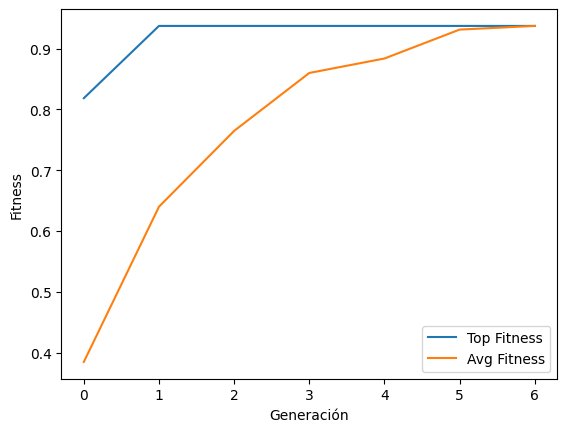

In [247]:
plt.plot(df_hist['fitness'], label='Top Fitness')
plt.plot(df_hist['Avg_Fitness'], label='Avg Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.show()

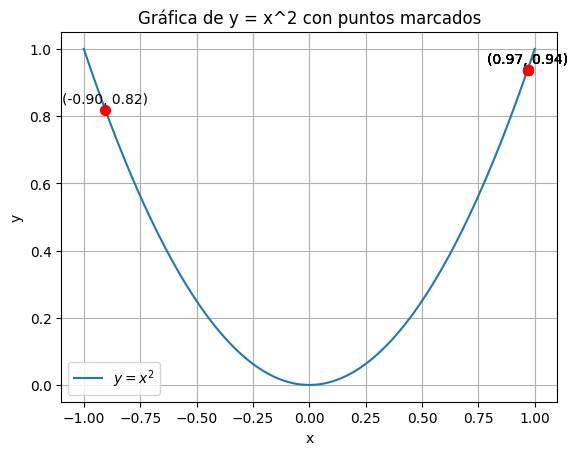

In [251]:
# Rango de x
x = np.linspace(-1, 1, 200)
y = x**2

pts_top_fitness = df_hist.loc[0:5, ['Valor', 'fitness']].to_numpy()

# Graficar la función
plt.plot(x, y, label='$y = x^2$')

# Marcar los puntos
for px, py in pts_top_fitness:
    plt.scatter(px, py, color='red', s=50, zorder=5)  # punto
    plt.text(px, py + 0.02, f"({px:.2f}, {py:.2f})", ha='center')  # etiqueta

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gráfica de y = x^2 con puntos marcados")
plt.legend()
plt.grid(True)
plt.show()